当批量大小等于训练集大小时，该算法即为梯度下降；批量大小为1即为随机梯度下降。

In [1]:
import mxnet as mx
from mxnet import autograd
from mxnet import gluon
from mxnet import ndarray as nd
import numpy as np
import random

mx.random.seed(1)
random.seed(1)

# 生成数据集。
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
X = nd.random_normal(scale=1, shape=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += .01 * nd.random_normal(scale=1, shape=y.shape)
dataset = gluon.data.ArrayDataset(X, y)

net = gluon.nn.Sequential()
net.add(gluon.nn.Dense(1))
square_loss = gluon.loss.L2Loss()

E:\software\anaconda\envs\gluon\lib\site-packages\urllib3\contrib\pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [2]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

def train(batch_size, lr, epochs, period):
    assert period >= batch_size and period % batch_size == 0
    net.collect_params().initialize(mx.init.Normal(sigma=1), force_reinit=True)
    # 随机梯度下降。
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': lr})
    data_iter = gluon.data.DataLoader(dataset, batch_size, shuffle=True)
    total_loss = [np.mean(square_loss(net(X), y).asnumpy())]
    for epoch in range(1, epochs + 1):
        # 学习率自我衰减。
        if epoch > 2:
            trainer.set_learning_rate(trainer.learning_rate * 0.1)
        for batch_i, (data, label) in enumerate(data_iter):
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            loss.backward()
            trainer.step(batch_size)
            if batch_i * batch_size % period == 0:
                total_loss.append(np.mean(square_loss(net(X), y).asnumpy()))
        print("Batch size %d, Learning rate %f, Epoch %d, loss %.4e" %
              (batch_size, trainer.learning_rate, epoch, total_loss[-1]))

    print('w:', np.reshape(net[0].weight.data().asnumpy(), (1, -1)),
          'b:', net[0].bias.data().asnumpy()[0], '\n')
    x_axis = np.linspace(0, epochs, len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

当批量大小为1时，训练使用的是随机梯度下降。在当前学习率下，目标函数值在早期快速下降后略有波动。当epoch大于2，学习率自我衰减后，目标函数值下降后较平稳。最终学到的参数值与真实值较接近。

Batch size 1, Learning rate 0.200000, Epoch 1, loss 5.5937e-05
Batch size 1, Learning rate 0.200000, Epoch 2, loss 8.0473e-05
Batch size 1, Learning rate 0.020000, Epoch 3, loss 4.9757e-05
w: [[ 1.999493   -3.39981651]] b: 4.19997 



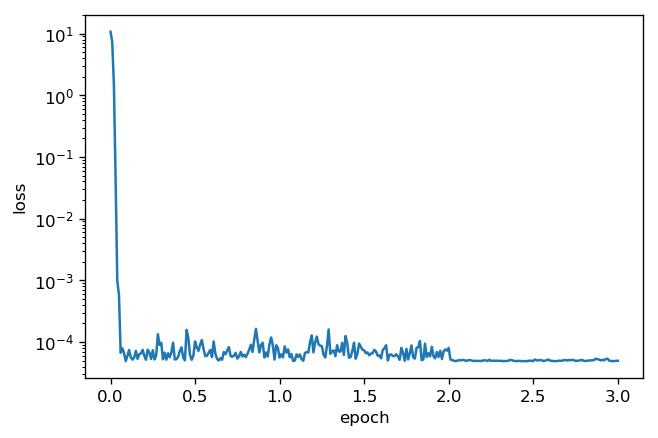

In [3]:
train(batch_size=1, lr=0.2, epochs=3, period=10)